#Импорт библиотек

In [ ]:
import librosa
from librosa.feature import melspectrogram
from librosa.core import load
from librosa.display import specshow
from librosa import power_to_db

import matplotlib.pyplot as plt

In [ ]:
import os
from tqdm import tqdm
import pickle
import pandas as pd
import numpy as np
import re

from librosa.feature import melspectrogram
from librosa.core import load as load_wav
from librosa import power_to_db

from torchvision.models import wide_resnet50_2
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
import soundfile as sf
import torch.nn.functional as F

In [ ]:
path  = 'D:/Downloads/all_folders/'
path_df = 'D:/Downloads/'

#Подготовка датасета + анализ данных

In [ ]:
df = pd.read_table(path_df+'speakers.tsv')
df.columns = ['GENDER', 'SUBSET', 'NAME']
df['READER'] = df.index
df.head()

,GENDER,SUBSET,NAME,READER
14,F,train-clean-360,Kristin LeMoine,14
16,F,train-clean-360,Alys AtteWater,16
17,M,train-clean-360,Gord Mackenzie,17
19,F,train-clean-100,Kara Shallenberg,19
20,F,train-other-500,Gesine,20


In [ ]:
pairs = [(list(df['READER'])[i], list(df['GENDER'])[i]) for i in range(len(list(df['GENDER'])))]
pairs[0]

(14, 'F')

Проходимся по папкам соответствующих людей, составляем новый датафрейм "путь - метка"

In [ ]:
from tqdm import tqdm
new_df = pd.DataFrame(columns=['path', 'target'])
idx = 0
for i in tqdm(range(len(pairs))):
  for folder in list(os.walk(path+str(pairs[i][0]))):
    for elem in folder[2]:
      if re.fullmatch('.*wav', elem):
        new_df.loc[idx] = [path + str(pairs[i][0]) +'/'+elem, pairs[i][1]]
        idx += 1
        break  #Берем по одному файлу из каждой папки, иначе датасет очень большой

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2484/2484 [04:06<00:00, 10.09it/s]


In [ ]:
print('Размер Датасета:', new_df.shape[0])

Размер Датасета: 5568


Преобразование меток в 0, 1

In [ ]:
new_df['target'] = new_df['target'].apply(lambda x: 0 if str(x).lower()=='f' else (1 if str(x).lower()=='m' else None))
new_df.head()

,path,target
0,D:/Downloads/all_folders/14/14_208_000001_0000...,0
1,D:/Downloads/all_folders/14/14_212_000006_0000...,0
2,D:/Downloads/all_folders/16/16_122827_000000_0...,0
3,D:/Downloads/all_folders/16/16_122828_000000_0...,0
4,D:/Downloads/all_folders/17/17_362_000000_0000...,1


In [ ]:
new_df.to_csv(path_df+'data2')

In [ ]:
df = pd.read_csv(path_df+'data2')[['path', 'target']]
df.head()

,path,target
0,D:/Downloads/all_folders/14/14_208_000001_0000...,0
1,D:/Downloads/all_folders/14/14_212_000006_0000...,0
2,D:/Downloads/all_folders/16/16_122827_000000_0...,0
3,D:/Downloads/all_folders/16/16_122828_000000_0...,0
4,D:/Downloads/all_folders/17/17_362_000000_0000...,1


In [ ]:
new_df['target'].value_counts()

1    2843
0    2725
Name: target, dtype: int64

In [ ]:
new_df.dropna(inplace=True)

небольшой фикс путей к файлам в датасете

In [ ]:
fixed_path = []
for elem in list(new_df['path']):
  s = elem.split('/')
  s.insert(-1, s[-1].split('_')[1])
  fixed_path.append('/'.join(s))
new_df['path'] = fixed_path

Проверка на сбалансированность классов

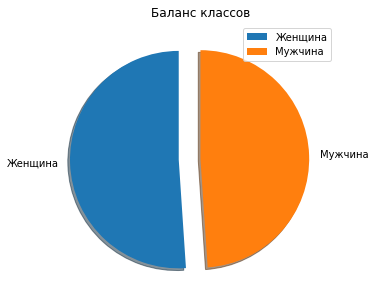

In [ ]:
plt.figure(figsize=(12,5))
labels =['Женщина', 'Мужчина']
myexplode = [0.2, 0]
plt.pie(list(new_df['target'].value_counts()), labels=labels, shadow=True,
        explode = myexplode,startangle=90)
plt.legend()

plt.title("Баланс классов")
plt.show()

как можно видеть, классы неплохо сбалансированы

Пример вывода спектрограммы 

In [ ]:
sample_rate = 11025
fft_size = 1024
overlap = 4
hop = fft_size // overlap
mels = 64

In [ ]:
wav_data, sr = load_wav(new_df['path'][0])

c:\users\michel\appdata\roaming\jetbrains\dataspell2021.3\projects\workspace\venv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[ 2.29028810e-05  1.18676406e-04 -1.27922540e-04 ... -3.28745204e-03
 -3.17329471e-03 -3.05037317e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


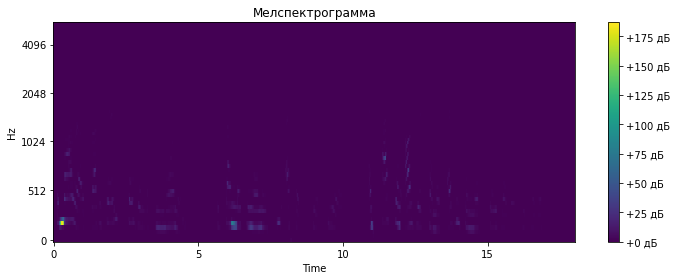

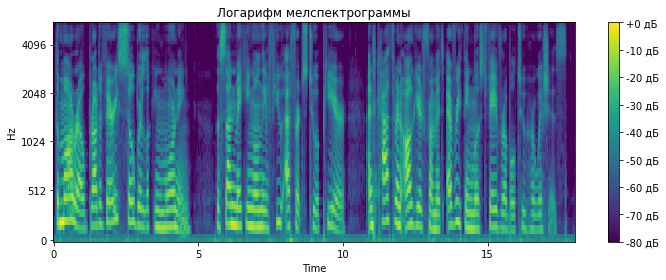

In [ ]:
mel_spec = melspectrogram(wav_data, n_fft=fft_size, hop_length=hop, n_mels=mels, 
                          fmax=sr//2)
plt.figure(figsize=(10, 4))
colors = 'viridis'
specshow(mel_spec, y_axis='mel', fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Мелспектрограмма')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
specshow(power_to_db(mel_spec, ref=np.max), y_axis='mel',
         fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Логарифм мелспектрограммы')
plt.tight_layout()
plt.show()

In [ ]:
file_paths = list(new_df['path'])
n_files = len(file_paths)
labels = list(new_df['target']) 
out_path = 'df_pickle'
feats = []

for i, (file_path, label) in tqdm(enumerate(zip(file_paths, labels))):
  try:
    wav_data, sr = load_wav(file_path, sr=sr)
    mel_spec = melspectrogram(wav_data, n_fft=fft_size, hop_length=hop, n_mels=mels, fmax=sr // 2)
    
    log_mel_spec = power_to_db(mel_spec, ref = np.max)
    feats.append({
      'file_path': file_path,
      'feature': log_mel_spec,
      'label': label
    })
  except:
    pass
feats = sorted(feats, key=lambda item: item["file_path"]) 
pickle.dump(feats, open(path_df+out_path, 'wb'))

#Строим модель

In [ ]:
sample_rate = 11025
fft_size = 1024
overlap = 4
hop = fft_size // overlap
mels = 64

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

в качестве модели использовал предобученный ResNet

In [ ]:
resnet = wide_resnet50_2(pretrained=True)

In [ ]:
resnet.fc = nn.Linear(2048, 2)
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7,7), stride = (2,2), padding = (3,3), bias = False)
network = resnet.to(device)

#Загружаем данные, разбиваем на Train/Test

Тут вместо path_df+out_path прописать путь до df_pickle

In [ ]:
pickle_data = pickle.load(open(path_df+out_path, 'rb'))

"подгонка" размерностей спектрограм 

In [ ]:
def prepare_shape(feature):
    tmp = feature
    N = 116 
    while tmp.shape[1] < N:
        tmp = np.hstack((tmp, tmp))
    tmp = tmp[np.newaxis, :, :N]
    return tmp

разбиваем на train/test в отношении 4:1

In [ ]:
def data_prepare(data):
  x_list = []
  y_list = []
  for i, row in enumerate(data):
    x_list.append(prepare_shape(row['feature']))
    y_list.append(row['label'])
  return np.asarray(x_list), np.asarray(y_list)

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(pickle_data, test_size=0.2, random_state=42)

x_tr, y_tr = data_prepare(data_train)
x_test, y_test = data_prepare(data_test)

Dataset

In [ ]:
from torch.utils.data import Dataset


class ClassificationDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [ ]:
train_dset = ClassificationDataset(x_tr, y_tr)
test_dset = ClassificationDataset(x_test, y_test)

Еще один пример вывода мелспектрограммы в качестве проверки

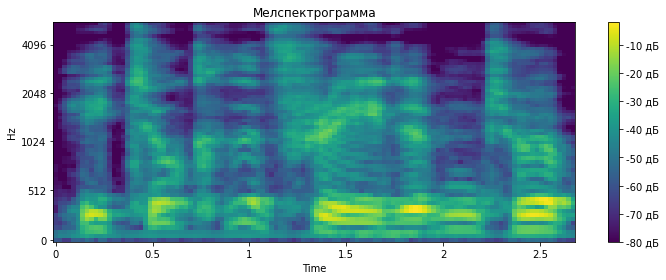

In [ ]:
sample_x, sample_y = test_dset[2]
plt.figure(figsize=(10, 4))
colors = 'viridis'
specshow(sample_x[0], y_axis='mel', fmax=sample_rate//2, x_axis='time', cmap=colors)
plt.colorbar(format='%+2.0f дБ')
plt.title('Мелспектрограмма')
plt.tight_layout()
plt.show()

Разбиваем на батчи

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dset, batch_size=64, shuffle=True)
val_loader = DataLoader(test_dset, batch_size=64, shuffle=False)

В качестве метрики использовал F1 меру 

In [ ]:
from sklearn.metrics import f1_score

Само обучение

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR

n_epoch = 35
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(network.parameters(), lr=0.0001)
scheduler = ExponentialLR(optimizer, gamma=0.9) #использование шедуллера немного улучшило результат

train_loss = []
val_loss = []

train_acc = []
val_acc = []
val_max_acc = 0
for e in range(n_epoch):
    print('epoch #', e)
    # train
    loss_list = []
    outputs = []
    targets = []
    for i_batch, sample_batched in enumerate(train_loader):
        x, y = sample_batched
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()

        output = network(x)
        outputs.append(output.cpu().detach().numpy().argmax(axis=1))
    
        target = y
        targets.append(target.cpu().detach().numpy())
        
        loss = criterion(output, target.long())
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    scheduler.step()
    y_true = np.hstack(targets)
    y_pred = np.hstack(outputs)
    acc = f1_score(y_true, y_pred, average='macro')
    train_loss.append(np.mean(loss_list))
    train_acc.append(acc)
    print('mean train loss:', train_loss[-1])
    print('train f1:', acc)
    
    #Test
    loss_list = []
    outputs = []
    targets = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(val_loader):
            x, y = sample_batched
            x, y = x.cuda(), y.cuda()
            output = network(x)
            outputs.append(output.cpu().detach().numpy().argmax(axis=1))

            target = y
            targets.append(target.cpu().detach().numpy())

            loss = criterion(output, target.long())
            loss_list.append(loss.item())
            
        y_true = np.hstack(targets)
        y_pred = np.hstack(outputs)
        acc = f1_score(y_true, y_pred, average='macro')
        if acc > val_max_acc:
          torch.save(network,'bestmodel.pth')
          val_max_acc = acc
        val_loss.append(np.mean(loss_list))
        val_acc.append(acc)
        print('mean val loss:', val_loss[-1])
        print('test f1:', acc)
        print('#####################################################')

epoch # 0
mean train loss: 0.32660085814339773
train f1: 0.8637040937148351
mean val loss: 0.25728099544843036
test f1: 0.9030470646256201
#####################################################
epoch # 1
mean train loss: 0.11174075796401926
train f1: 0.9638430040114887
mean val loss: 0.24315564334392548
test f1: 0.9146638928198492
#####################################################
epoch # 2
mean train loss: 0.02567181870274778
train f1: 0.9930382933195115
mean val loss: 0.29808535137110287
test f1: 0.9200375512034371
#####################################################
epoch # 3
mean train loss: 0.005972090941421422
train f1: 0.9993262671554936
mean val loss: 0.324009258300066
test f1: 0.9227200129063483
#####################################################
epoch # 4
mean train loss: 0.001791495192446746
train f1: 0.9997754223851645
mean val loss: 0.3468666113913059
test f1: 0.9226800962019596
#####################################################
epoch # 5
mean train loss: 0.0024870

Лучшее качество

In [ ]:
print('max F1:', val_max_acc)

max F1: 0.9272463106734276


In [ ]:
network = torch.load('bestmodel.pth')

#Вывод графиков лосса и метрики соответственно

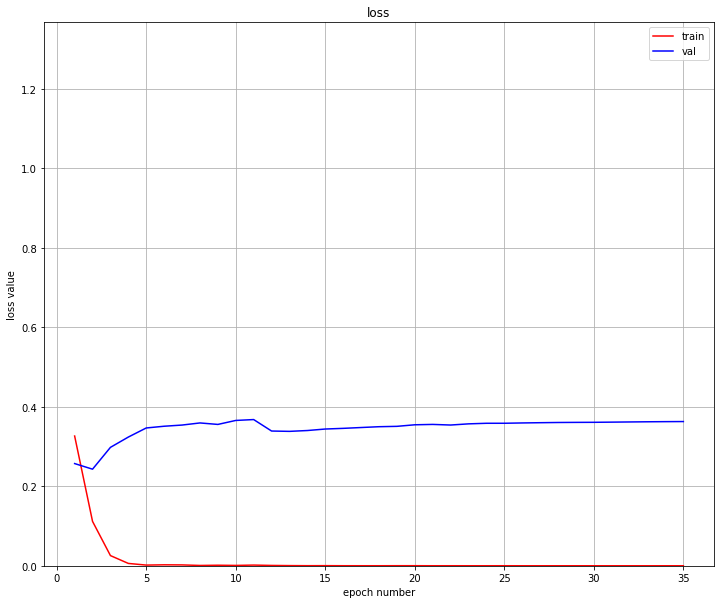

In [ ]:
epochs = np.arange(1, n_epoch+1)

plt.figure(figsize=(12,10))
axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(val_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, val_loss, 'b', label='val')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()

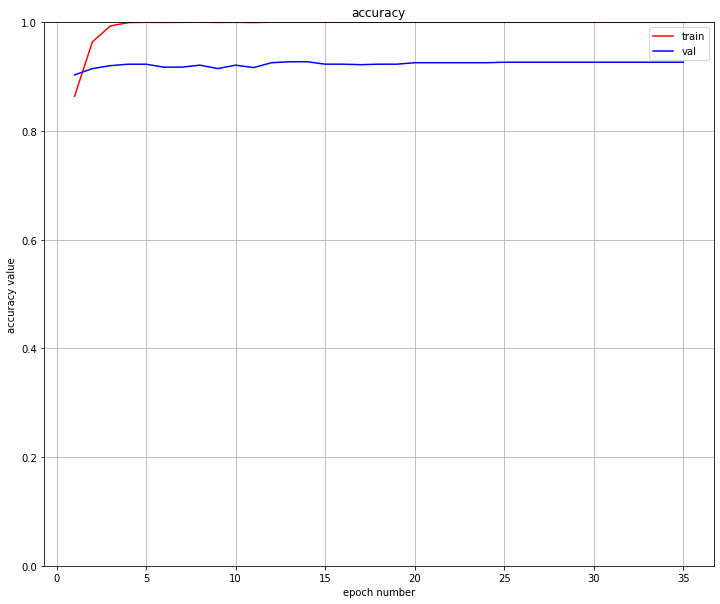

In [ ]:
plt.figure(figsize=(12,10))
axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, val_acc, 'b', label='val')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()

Как можно видеть, в районе 5й эпохи лосс и качество перестают сильно меняться

#Выводы:


1.   Дообученная модель ResNet показала качество F1 = 0.93
2.   Можно улучшить качество путем добавления большего количества данных в наш датасет (всего дорожек в районе 400к, я же использовал всего около 5к
3. Также можно попробовать улучшить качество модели с помощью использования методанных о каждом человеке, cодержащиеся в LibriTTS

